## 0. Load processed cases and features from exercise 1
### Load new case_reversed and updated precomputed cases data

In [1]:
# load the cases from exercise 1 (so we use the same subset of case_metadata)
import pandas as pd
saved_doc_filename = "cases_with_doc_1000.pkl"
cases = pd.read_pickle(saved_doc_filename)

In [2]:
# load the case metadata
case_metadata_path = "../data/case_metadata.csv"
case_metadata = pd.read_csv(case_metadata_path)
case_metadata.head() # print first few elements

caseid  case_reversed  judge_id    year  log_cites
0  X3JGGO              0    1653.0  1925.0   1.098612
1  X3OH3J              0    1034.0  1924.0   1.609438
2  X3U0KO              0    2303.0  1925.0   1.791759
3  X53HAD              0    1764.0  1924.0        NaN
4  X9VC5V              0     493.0  1925.0        NaN

In [3]:
# add the case metadata to the used subset of cases
for index, row in cases.iterrows():
    cases.at[index, 'judge_id'] = case_metadata.loc[index]['judge_id']
    cases.at[index, 'year'] = case_metadata.loc[index]['year']
    cases.at[index, 'log_cites'] = case_metadata.loc[index]['log_cites']
cases.fillna(0, inplace=True) # replace all NaN with 0
cases.head()

caseid  case_reversed                                               text  \
3   X53HAD              0   ROGERS , Circuit Judge.\nThe complainant is a...   
5   X9VAJI              0   PER CURIAM.\nThe collector of internal revenu...   
14  X3C0H6              0   BINGHAM , Circuit Judge.\nThe defendant Lee, ...   
16  X3IKGJ              0   ROSS , Circuit Judge.\nThis is one of a numbe...   
19  X9VBDP              0   GIBSON , District Judge.\nIn the court below ...   

      year                                                doc  judge_id  \
3   1924.0  ( , ROGERS, ,, Circuit, Judge, ., \n, The, com...    1764.0   
5      0.0  ( , PER, CURIAM, ., \n, The, collector, of, in...       0.0   
14  1926.0  ( , BINGHAM, ,, Circuit, Judge, ., \n, The, de...     150.0   
16  1925.0  ( , ROSS, ,, Circuit, Judge, ., \n, This, is, ...    1782.0   
19  1925.0  ( , GIBSON, ,, District, Judge, ., \n, In, the...     741.0   

    log_cites  
3    0.000000  
5    0.000000  
14   1.386294  
16   0.000000  
19   0.693147

## 1. Model Prediction of reversed
### Take your best hyperparameters for the logistic regression model from Problem Set 1 (or find them with a new model). Use cross_val_predict() to form model predictions of reversed for each observation. Construct a confusion matrix for the predictions. Report the precision_recall_curve() and roc_curve(). Make a calibration plot (as in Bansak et al 2018, appendix page 24).

In [4]:
# load the n-gram features from Exercise1
saved_features_filename = 'features_1000.pkl'
features = pd.read_pickle(saved_features_filename)

In [5]:
import numpy as np
X = np.array(features)
X /= X.std()
Y = np.array(cases['case_reversed'])
print("X: {}, Y: {}".format(X.shape, Y.shape))

X: (1000, 1000), Y: (1000,)


In [6]:
# create training and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [7]:
# train logistic regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(penalty='l2', C=0.0001) # parameters from gridserach from Exercise 1
log_reg.fit(x_train, y_train)
print("Training score: {}".format(log_reg.score(x_train, y_train)))

C:\Users\Dominik\Anaconda3\envs\RJ\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training score: 0.63875


In [8]:
# prediction
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

def prediction_score(x, y, model, prefix):
    print("----------------------------------------------------------------")
    print(prefix)
    #pred = model.predict(x)
    pred = cross_val_predict(model, x, y, cv=5) # cross val prediction
    
    # -----------------------------------------------------------------------------------------
    
    conf_mat = confusion_matrix(y, pred)
    print("[{}] Confusion matrix:[[TN, FP], [FN, TP]]".format(prefix))
    print(conf_mat)
    
    # -----------------------------------------------------------------------------------------
    
    precision, recall, thresholds = precision_recall_curve(y, pred)
    plt.figure('Precision Recall')
    plt.step(recall, precision, label='{}'.format(prefix))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower left")
        
    # -----------------------------------------------------------------------------------------
    
    fpr, tpr, thresholds = roc_curve(y, pred)
    area = auc(fpr, tpr)
    plt.figure('ROC')
    plt.plot(fpr, tpr, label='{}: AUC={:0.2f}'.format(prefix, area))
    plt.grid(True)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
        
    # -----------------------------------------------------------------------------------------
    
    if hasattr(model, "predict_proba"):
        prob_pos = model.predict_proba(x)[:, 1]
    else:  # use decision function
        prob_pos = model.decision_function(x)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        
    fraction_of_positives, mean_predicted_value = calibration_curve(y, prob_pos, n_bins=10)
    
    plt.figure('Calibration')
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='{}'.format(prefix))
    plt.title('Calibration')
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    plt.legend(loc="lower right")
    
    plt.figure('Histogram')
    plt.hist(pred, range=(0, 1), bins=10, label='{}'.format(prefix), histtype="step", lw=2)
    plt.title('Histogram')
    plt.xlabel('Predicted probability')
    plt.ylabel('Count')
    plt.legend(loc="upper center")

    # -----------------------------------------------------------------------------------------

    acc = accuracy_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    f1 = f1_score(y, pred)
    print("[{}] Accuracy: {:0.3f}, F1: {:0.3f}, (Precision: {:0.3f}, Recall: {:0.3f})".format(prefix, acc, f1, prec, rec))
    print("----------------------------------------------------------------")
    
    
# evaluate model and show confustion matrix, precision-recall-curve, roc-curve
prediction_score(x_train, y_train, log_reg, "Training Set")
prediction_score(x_test, y_test, log_reg, "Test Set")

----------------------------------------------------------------
Training Set


C:\Users\Dominik\Anaconda3\envs\RJ\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Dominik\Anaconda3\envs\RJ\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Dominik\Anaconda3\envs\RJ\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Dominik\Anaconda3\envs\RJ\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Dominik\Anaconda3\envs\RJ\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed

[Training Set] Confusion matrix:[[TN, FP], [FN, TP]]
[[ 19 274]
 [ 28 479]]
[Training Set] Accuracy: 0.623, F1: 0.760, (Precision: 0.636, Recall: 0.945)
----------------------------------------------------------------
----------------------------------------------------------------
Test Set


C:\Users\Dominik\Anaconda3\envs\RJ\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Dominik\Anaconda3\envs\RJ\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Dominik\Anaconda3\envs\RJ\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Dominik\Anaconda3\envs\RJ\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Dominik\Anaconda3\envs\RJ\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed

[Test Set] Confusion matrix:[[TN, FP], [FN, TP]]
[[  6  61]
 [  9 124]]
[Test Set] Accuracy: 0.650, F1: 0.780, (Precision: 0.670, Recall: 0.932)
----------------------------------------------------------------


## 2. Elastic net model
### Scale your n-gram frequencies while maintaining sparsity, as discussed in class. Train an elastic net model to predict log citations to a case (log_cites). Run cross_val_predict() to form model predictions and report a scatter plot of true and predicted values. 

In [9]:
# scale frequencies (divide by std but do not center mean)
import numpy as np
X = np.array(features)
X /= X.std()
Y = np.array(cases['log_cites'])
print("X: {}, Y: {}".format(X.shape, Y.shape))

X: (1000, 1000), Y: (1000,)


In [10]:
# train elastic net model
from sklearn.linear_model import ElasticNet
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

elastic = ElasticNet(random_state=0)
elastic.fit(x_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

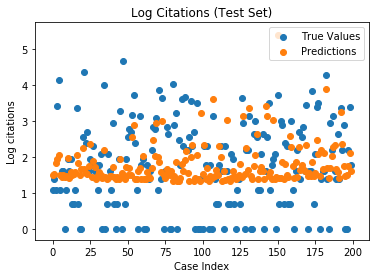

In [11]:
# evaluate and plot

def predict_elastic(x, y, model, prefix):
    #pred = model.predict(x)
    pred = cross_val_predict(model, x, y, cv=5) # cross val prediction
    
    # -----------------------------------------------------------------------------------------
    
    plt.figure(prefix)
    plt.scatter(range(len(y)), y, label='True Values')
    plt.scatter(range(len(y)), pred, label='Predictions')
    plt.title('Log Citations ({})'.format(prefix))
    plt.xlabel('Case Index')
    plt.ylabel('Log citations')
    plt.legend(loc="upper right")
    
    # -----------------------------------------------------------------------------------------
    
    
# evaluate model and show confustion matrix, precision-recall-curve, roc-curve
predict_elastic(x_train, y_train, elastic, "Training Set")
predict_elastic(x_test, y_test, elastic, "Test Set")

## 3.
### Use the judge identifiers (judge_id) to produce the average citations to cases for each judge. Then estimate a two-stage least-squares model with Z as average citations of the judge, X as citations to the case, and Y as whether the case was reversed. Include year fixed effects. You can do this in two stages, by regressing X on Z to get Xpred, and then regressing Y on Xpred. Report estimates for coefficient and standard error on Xpred. Compare to the parameter estimates for the OLS regression of Y on X.

In [12]:
# Skippped

## 4. Latent Dirichlet Allocation
### Train LDA on the cases. Produce word clouds for the topics. Inspect the word clouds for different models to decide on the right number of topics.

In [13]:
# clean documents (same as in Exercise 1)

from string import punctuation
translator = str.maketrans('','',punctuation) # maps punctuations to None

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english')) # unimportant words like the, an, at, for etc.

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english') # extracts word stem (currently use token.lemma_ instead of stemmer)

def normalize_doc(doc):
    ''' Input spacy doc and return clean list of normalized tokens '''
    tokens = []    
    for sent in doc.sents:  
        for token in sent:
            # discard non informative tokens:
            #   'new line' (whitespaces) -> token.is_space
            #   pure punctuation -> token.is_punct
            #   stop words -> token.is_stop or word in stoplist (in case stoplist contains mroe words)

            # simplify strings: 
            #   lemma (better than wordstem) -> token.lemma_
            #   lowercase -> str.lower()
            #   remove punctuation that are part of words (e.g. U.S.) -> str.translate(translator)
            #   replace digits with '#' -> token.isdigit()

            word = token.lemma_.lower().translate(translator)    
            if word.isdigit(): # token.is_digit only works for whole numbers, like_num also includes spelled out numbers (which we could also think of discarding)
                word = "#" 
            discard_token = token.is_space or token.is_punct or token.is_stop or word in stoplist
    
            if not discard_token:
                #tokens.append((word, token)) # here we don't care about the tokens anymore
                tokens.append(word)
        
    return tokens

cases['doc_cleaned'] = cases['doc'].apply(normalize_doc)
cases['doc_cleaned'].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dominik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3     [rogers, circuit, judge, complainant, physicia...
5     [per, curiam, collector, internal, revenue, fi...
14    [bingham, circuit, judge, defendant, lee, indi...
16    [ross, circuit, judge, number, similar, case, ...
19    [gibson, district, judge, court, norfolk, west...
Name: doc_cleaned, dtype: object

In [14]:
###
# Latent Dirichlet Allocation
###

# cleaned document
doc_clean = cases['doc_cleaned'].values

# randomize document order
#from random import shuffle
#shuffle(doc_clean)

# creating the term dictionary
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)

# creating the document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# train LDA with 10 topics and print
from gensim.models.ldamodel import LdaModel
lda = LdaModel(doc_term_matrix, num_topics=10, 
               id2word = dictionary, passes=3)
lda.show_topics(formatted=False)

C:\Users\Dominik\Anaconda3\envs\RJ\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[(0,
  [('#', 0.07817525),
   ('court', 0.009058738),
   ('pron', 0.008975559),
   ('v', 0.0071393587),
   ('act', 0.007007842),
   ('case', 0.0065826224),
   ('claim', 0.005992127),
   ('tax', 0.005778953),
   ('company', 0.0055000335),
   ('section', 0.0051221075)]),
 (1,
  [('#', 0.083649635),
   ('court', 0.014613141),
   ('pron', 0.0097540105),
   ('v', 0.006990329),
   ('state', 0.006336399),
   ('district', 0.0054354393),
   ('school', 0.005365792),
   ('case', 0.0052856617),
   ('sct', 0.0048823366),
   ('rule', 0.0048161177)]),
 (2,
  [('#', 0.07039909),
   ('court', 0.014968611),
   ('pron', 0.008766655),
   ('gas', 0.0060131405),
   ('case', 0.005564078),
   ('v', 0.005540027),
   ('commission', 0.0055143316),
   ('state', 0.005062296),
   ('district', 0.0046421858),
   ('government', 0.0043291124)]),
 (3,
  [('#', 0.12787203),
   ('v', 0.013374353),
   ('court', 0.011996477),
   ('sct', 0.008022702),
   ('pron', 0.0077708354),
   ('us', 0.0073667574),
   ('case', 0.00611313

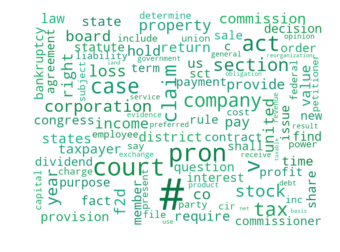

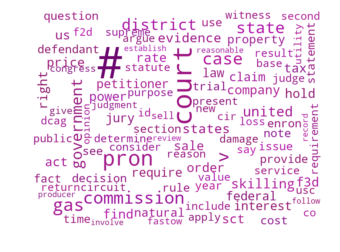

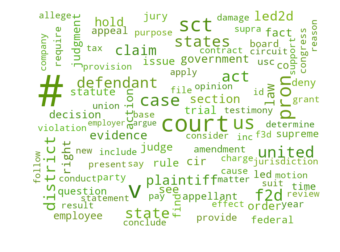

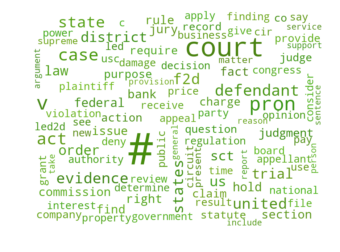

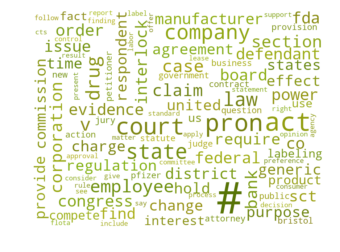

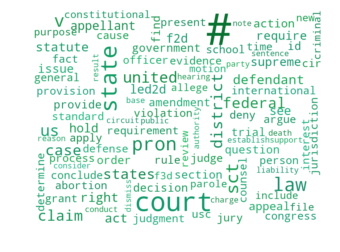

In [15]:
###
# LDA Word Clouds
###

from numpy.random import randint
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# make directory if not exists
from os import mkdir
try:
    mkdir('lda')
except:
    pass

# make word clouds for the topics
for i, weights in lda.show_topics(num_topics=-1, num_words=100, formatted=False):
    #logweights = [w[0], np.log(w[1]) for w in weights]
    maincol = randint(0,360)
    def colorfunc(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):   
        color = randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color,randint(65, 75)+font_size / 7, randint(35, 45)-font_size / 10)   

    
    wordcloud = WordCloud(background_color="white", 
                          ranks_only=False, 
                          max_font_size=120,
                          color_func=colorfunc,
                          height=600,width=800).generate_from_frequencies(dict(weights))

    plt.clf()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

## 5. Deep Learning
### Replicate your sklearn logistic regression model (no hidden layers, L2 regularization, and sigmoid output layer) in Keras or some other deep learning library. Compare performance. Now add two hidden layers, dropout, and batch normalization. Compare performance.

#### Since it said 'or some other deep learning library' I decided to use Pytorch, since I most familiar with this one

In [16]:
# load the n-gram features from Exercise1
saved_features_filename = 'features_1000.pkl'
features = pd.read_pickle(saved_features_filename)

# scale without destroying sparsity
import numpy as np
X = np.array(features)
X /= X.std()
Y = np.array(cases['case_reversed'])
print("X: {}, Y: {}".format(X.shape, Y.shape))

# create training and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

X: (1000, 1000), Y: (1000,)


In [17]:
import torch
import torch.nn as nn
import torch.utils.data
from sklearn.metrics import accuracy_score

In [18]:
# data setup

# create tensors from the training data (because the training set is rather small we can load everything into one big tensor)
x_train_tensor = torch.as_tensor(x_train.astype(np.float32))
y_train_tensor = torch.as_tensor(y_train.astype(np.float32))
x_test_tensor = torch.as_tensor(x_test.astype(np.float32))
y_test_tensor = torch.as_tensor(y_test.astype(np.float32))
    
in_dim = x_train_tensor.shape[1]
out_dim = 1

# device to use (GPU if available)
if torch.cuda.is_available():
    device = torch.device('cuda') 
    print("Running on GPU ({})\n".format(torch.cuda.get_device_name(0)))
else: 
    device = torch.device('cpu')
    print("Running on CPU. Training will be very slow!")


# create dataloaders
#batch_size = x_train_tensor.shape[0] # because its only a rather small dataset we can use the entire set in one batch
batch_size = 128
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle = True)


Running on GPU (GeForce GTX 960M)



In [19]:
# model setup

class LogisticRegressionNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.sigmoid = nn.Sigmoid()        
        
    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
        
class DeepLogisticRegressionNN(nn.Module):
    def __init__(self, in_dim, out_dim, drop_prob = 0.5):
        super().__init__()
        self.fc_1 = nn.Linear(in_dim, 256)
        self.dropout_1 = nn.Dropout(p=drop_prob)
        self.bn_1 = nn.BatchNorm1d(256)
        self.sigmoid_1 = nn.Sigmoid()        
        self.fc_2 = nn.Linear(256, 128)
        self.dropout_2 = nn.Dropout(p=drop_prob)
        self.bn_2 = nn.BatchNorm1d(128)
        self.sigmoid_2 = nn.Sigmoid()        
        self.fc_3 = nn.Linear(128, out_dim)
        self.sigmoid_3 = nn.Sigmoid()        
        
    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout_1(x)
        x = self.bn_1(x)
        x = self.sigmoid_1(x)
        
        x = self.fc_2(x)
        x = self.dropout_2(x)
        x = self.bn_2(x)
        x = self.sigmoid_2(x)
        
        x = self.fc_3(x)
        x = self.sigmoid_3(x)
        
        return x

In [20]:
# trainin loop

def train_model(model, criterion, optimizer, train_loader, test_loader, num_epoch):
    # push model and data to device
    model.to(device)
    
    for epoch in range(num_epoch):    
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            y_pred = y_pred.squeeze()

            # Compute and print loss
            loss = criterion(y_pred, y)
            print("Training [Epoch {}]: {}".format(epoch, loss.item()))

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            total_loss = 0
            total_acc = 0
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)

                y_pred_test = model(x)
                y_pred_test = y_pred_test.squeeze()

                loss_test = criterion(y_pred_test, y)
                acc = accuracy_score(y.cpu().numpy(), y_pred_test.cpu().numpy() > 0.5)
                total_loss += loss_test.item()
                total_acc += acc
            print("Testing [Epoch {}]: loss: {}, accuracy: {}".format(epoch, total_loss / len(test_loader), total_acc / len(test_loader)))



In [21]:
# constant parameters for both models

# same as used for sklearn.LogisticRegression
C = 1 / 0.0001 # sklearn uses C as the inverse regularization strength -> invert it for the optimizer

# setup the loss function (cross entropy loss)
criterion = torch.nn.BCELoss(reduction='mean')
#criterion = torch.nn.CrossEntropyLoss(reduction='mean')

num_epoch = 50

In [22]:
# model 1: linear layer and sigmoid (same as sklearn.LogisticRegression)

# create the model (logistic regression)
logreg_model = LogisticRegressionNN(in_dim, out_dim)    

# setup optimizer (using same C as for l2 penalty of sklearn.LogisticRegression for weight_decay (L2 regularization))
optimizer = torch.optim.Adam(logreg_model.parameters(), lr=0.001, weight_decay=C)
#optimizer = torch.optim.SGD(logreg_model.parameters(), lr=0.01, weight_decay=C)

# train the model
train_model(logreg_model, criterion, optimizer, train_loader, test_loader, num_epoch)

Training [Epoch 0]: 0.6719420552253723
Training [Epoch 0]: 0.7289210557937622
Training [Epoch 0]: 0.6898173093795776
Training [Epoch 0]: 0.7393450736999512
Training [Epoch 0]: 0.6886481642723083
Training [Epoch 0]: 0.6658092141151428
Training [Epoch 0]: 0.6926373243331909
Testing [Epoch 0]: loss: 0.6620909869670868, accuracy: 0.6553819444444444
Training [Epoch 1]: 0.680073618888855
Training [Epoch 1]: 0.7173099517822266
Training [Epoch 1]: 0.6783111095428467
Training [Epoch 1]: 0.7050502300262451
Training [Epoch 1]: 0.6790549755096436
Training [Epoch 1]: 0.6596621870994568
Training [Epoch 1]: 0.6580206751823425
Testing [Epoch 1]: loss: 0.664680153131485, accuracy: 0.62890625
Training [Epoch 2]: 0.6676100492477417
Training [Epoch 2]: 0.6842806339263916
Training [Epoch 2]: 0.7003625631332397
Training [Epoch 2]: 0.6564393639564514
Training [Epoch 2]: 0.7126455307006836
Training [Epoch 2]: 0.6765271425247192
Training [Epoch 2]: 0.6850026845932007
Testing [Epoch 2]: loss: 0.6758488416671753

Training [Epoch 23]: 0.6927706003189087
Training [Epoch 23]: 0.692108154296875
Testing [Epoch 23]: loss: 0.6925503015518188, accuracy: 0.6831597222222222
Training [Epoch 24]: 0.6927345991134644
Training [Epoch 24]: 0.6928116083145142
Training [Epoch 24]: 0.692696213722229
Training [Epoch 24]: 0.692445695400238
Training [Epoch 24]: 0.6926254034042358
Training [Epoch 24]: 0.6926957368850708
Training [Epoch 24]: 0.6932636499404907
Testing [Epoch 24]: loss: 0.692415326833725, accuracy: 0.6853298611111112
Training [Epoch 25]: 0.6925573945045471
Training [Epoch 25]: 0.6928210258483887
Training [Epoch 25]: 0.6927378177642822
Training [Epoch 25]: 0.6924804449081421
Training [Epoch 25]: 0.6923089027404785
Training [Epoch 25]: 0.6930601000785828
Training [Epoch 25]: 0.6935040950775146
Testing [Epoch 25]: loss: 0.6924700438976288, accuracy: 0.6922743055555556
Training [Epoch 26]: 0.6927605867385864
Training [Epoch 26]: 0.6928075551986694
Training [Epoch 26]: 0.6925715208053589
Training [Epoch 26]

Testing [Epoch 46]: loss: 0.6925368905067444, accuracy: 0.703125
Training [Epoch 47]: 0.6924322843551636
Training [Epoch 47]: 0.6930243968963623
Training [Epoch 47]: 0.6927560567855835
Training [Epoch 47]: 0.6928073763847351
Training [Epoch 47]: 0.6929550170898438
Training [Epoch 47]: 0.6923556327819824
Training [Epoch 47]: 0.6925119161605835
Testing [Epoch 47]: loss: 0.692413866519928, accuracy: 0.6822916666666667
Training [Epoch 48]: 0.6928244829177856
Training [Epoch 48]: 0.692711591720581
Training [Epoch 48]: 0.6926370859146118
Training [Epoch 48]: 0.6924492120742798
Training [Epoch 48]: 0.6926882266998291
Training [Epoch 48]: 0.6925610303878784
Training [Epoch 48]: 0.6933186054229736
Testing [Epoch 48]: loss: 0.6925323307514191, accuracy: 0.6840277777777778
Training [Epoch 49]: 0.6928315758705139
Training [Epoch 49]: 0.692585825920105
Training [Epoch 49]: 0.692745566368103
Training [Epoch 49]: 0.6927846074104309
Training [Epoch 49]: 0.6926352977752686
Training [Epoch 49]: 0.692740

In [23]:
# Model 2 (more layers): 2 hidden layers, dropout after each layer (except last), batchnorms and sigmoids as activation

# create the model (logistic regression)
deep_logreg_model = DeepLogisticRegressionNN(in_dim, out_dim)   

# setup optimizer (using same C as for l2 penalty of sklearn.LogisticRegression for weight_decay (L2 regularization))
optimizer = torch.optim.Adam(deep_logreg_model.parameters(), lr=0.001, weight_decay=C)
#optimizer = torch.optim.SGD(logreg_model.parameters(), lr=0.01, weight_decay=C)

# train the model
train_model(deep_logreg_model, criterion, optimizer, train_loader, test_loader, num_epoch)

Training [Epoch 0]: 0.6608635783195496
Training [Epoch 0]: 0.6565852165222168
Training [Epoch 0]: 0.6519464254379272
Training [Epoch 0]: 0.6896683573722839
Training [Epoch 0]: 0.671599268913269
Training [Epoch 0]: 0.6726146936416626
Training [Epoch 0]: 0.6713253259658813
Testing [Epoch 0]: loss: 0.6518356204032898, accuracy: 0.7035590277777778
Training [Epoch 1]: 0.6722421646118164
Training [Epoch 1]: 0.660192608833313
Training [Epoch 1]: 0.6909776926040649
Training [Epoch 1]: 0.6728845238685608
Training [Epoch 1]: 0.6746054887771606
Training [Epoch 1]: 0.668046772480011
Training [Epoch 1]: 0.6906254887580872
Testing [Epoch 1]: loss: 0.6619343757629395, accuracy: 0.6853298611111112
Training [Epoch 2]: 0.680847704410553
Training [Epoch 2]: 0.67219078540802
Training [Epoch 2]: 0.6788703203201294
Training [Epoch 2]: 0.675643801689148
Training [Epoch 2]: 0.6708848476409912
Training [Epoch 2]: 0.6683759689331055
Training [Epoch 2]: 0.6859652400016785
Testing [Epoch 2]: loss: 0.6626684665679

Training [Epoch 23]: 0.6930304765701294
Training [Epoch 23]: 0.6924329400062561
Training [Epoch 23]: 0.6924318671226501
Training [Epoch 23]: 0.6922992467880249
Testing [Epoch 23]: loss: 0.6924398839473724, accuracy: 0.7157118055555556
Training [Epoch 24]: 0.6926605701446533
Training [Epoch 24]: 0.6928543448448181
Training [Epoch 24]: 0.6927710771560669
Training [Epoch 24]: 0.6929013729095459
Training [Epoch 24]: 0.6926308274269104
Training [Epoch 24]: 0.6929807066917419
Training [Epoch 24]: 0.6925044059753418
Testing [Epoch 24]: loss: 0.6926262378692627, accuracy: 0.7096354166666667
Training [Epoch 25]: 0.6928370594978333
Training [Epoch 25]: 0.6928876638412476
Training [Epoch 25]: 0.6928297281265259
Training [Epoch 25]: 0.6928940415382385
Training [Epoch 25]: 0.6928060054779053
Training [Epoch 25]: 0.6930059194564819
Training [Epoch 25]: 0.6928442716598511
Testing [Epoch 25]: loss: 0.692735880613327, accuracy: 0.7217881944444444
Training [Epoch 26]: 0.6929590702056885
Training [Epoch 

Training [Epoch 46]: 0.6931041479110718
Training [Epoch 46]: 0.6930785179138184
Training [Epoch 46]: 0.6930945515632629
Testing [Epoch 46]: loss: 0.6930519938468933, accuracy: 0.7278645833333333
Training [Epoch 47]: 0.6930949687957764
Training [Epoch 47]: 0.6930856704711914
Training [Epoch 47]: 0.6930716037750244
Training [Epoch 47]: 0.6930859684944153
Training [Epoch 47]: 0.6931027173995972
Training [Epoch 47]: 0.693130612373352
Training [Epoch 47]: 0.6930968761444092
Testing [Epoch 47]: loss: 0.6930570900440216, accuracy: 0.71875
Training [Epoch 48]: 0.693111777305603
Training [Epoch 48]: 0.6930883526802063
Training [Epoch 48]: 0.6931145191192627
Training [Epoch 48]: 0.6931073069572449
Training [Epoch 48]: 0.6930942535400391
Training [Epoch 48]: 0.6930924654006958
Training [Epoch 48]: 0.6930204629898071
Testing [Epoch 48]: loss: 0.6930522322654724, accuracy: 0.7126736111111112
Training [Epoch 49]: 0.6930879354476929
Training [Epoch 49]: 0.6930786371231079
Training [Epoch 49]: 0.69312

### Observation: 
#### sklearn.LogisticRegression: accuracy = 0.65
#### Simple network with one linear layer and sigmoid: accuracy = 0.70
#### Slightly deeper network (2 hidden layers, dropout and batchnorm): 0.72

#### The deeper network performs best, which is to be expected, as it has much more expressive power. And also the simple network seems to outperform the logistic regression, although in theory they are the same. A reason for the difference might be the use of stochastic gradient descent compared to evaluating the full dataset at once.